In [1]:
# PCA : 适于线性数据分析
import numpy as np
from sklearn import decomposition

# 5 dims, 后面3个依赖于前面2个维度
x1 = np.random.normal(size=250)
x2 = np.random.normal(size=250)
x3 = 2*x1 + 3*x2
x4 = 4*x1 - x2
x5 = x3 + 2*x4

# 创建特征数据集
X = np.c_[x1, x3, x2, x5, x4]

# PCA
pca = decomposition.PCA()
pca.fit(X)

# variance
variances = pca.explained_variance_
print('\nVariances in decreasing order:\n',variances)

# 如果一个特定的维度是有用的，那么它应该有一个收敛的方差
thresh_variance = 0.8
num_useful_dims = len(np.where(variances > thresh_variance)[0])
print('\nNumber of useful dimensions: ',num_useful_dims)

# 根据结果，PCA有两个维度是有效地
pca.n_components = num_useful_dims

# 将数据集从5维转换为二维
X_new = pca.fit_transform(X)
print('\nShape before:', X.shape)
print('\nShape after:',X_new.shape)


Variances in decreasing order:
 [1.22885669e+02 1.08059276e+01 2.23324851e-31 7.59241813e-32
 1.83551424e-32]

Number of useful dimensions:  2

Shape before: (250, 5)

Shape after: (250, 2)


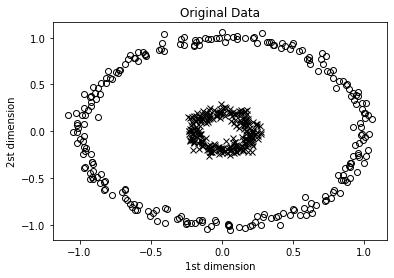

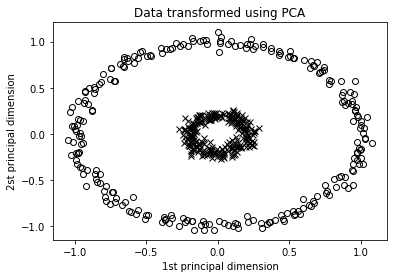

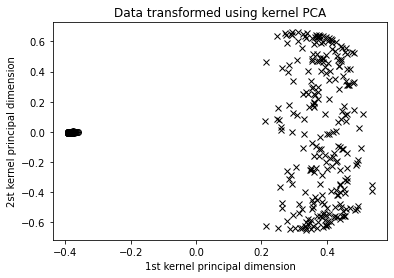

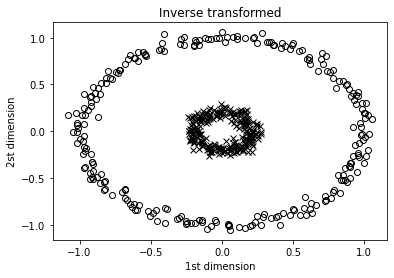

In [3]:
# Kernel PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

# random seeds, generate test datasets
np.random.seed(7)
X, y = make_circles(n_samples=500, factor=0.2, noise=0.04)

# pca
pca = PCA()
X_pca = pca.fit_transform(X)

# kernel pca
kernel_pca = KernelPCA(kernel='rbf', fit_inverse_transform=True, gamma=10)
X_kernel_pca = kernel_pca.fit_transform(X)
X_inverse = kernel_pca.inverse_transform(X_kernel_pca)

# plot original data
class_0 = np.where(y == 0)
class_1 = np.where(y == 1)
plt.figure()
plt.title('Original Data')
plt.plot(X[class_0, 0], X[class_0, 1], 'ko', mfc='none')
plt.plot(X[class_1, 0], X[class_1, 1], 'kx')
plt.xlabel('1st dimension')
plt.ylabel('2st dimension')

# plot pca data
plt.figure()
plt.title('Data transformed using PCA')
plt.plot(X_pca[class_0, 0], X_pca[class_0, 1], 'ko', mfc='none')
plt.plot(X_pca[class_1, 0], X_pca[class_1, 1], 'kx')
plt.xlabel('1st principal dimension')
plt.ylabel('2st principal dimension')

# plot kernel pca data
plt.figure()
plt.title('Data transformed using kernel PCA')
plt.plot(X_kernel_pca[class_0, 0], X_kernel_pca[class_0, 1], 'ko', mfc='none')
plt.plot(X_kernel_pca[class_1, 0], X_kernel_pca[class_1, 1], 'kx')
plt.xlabel('1st kernel principal dimension')
plt.ylabel('2st kernel principal dimension')

# 用核方法将数据转换回原始空间，查看是否有可逆关系
plt.figure()
plt.title('Inverse transformed')
plt.plot(X_inverse[class_0, 0], X_inverse[class_0, 1], 'ko', mfc='none')
plt.plot(X_inverse[class_1, 0], X_inverse[class_1, 1], 'kx')
plt.xlabel('1st dimension')
plt.ylabel('2st dimension')

plt.show()

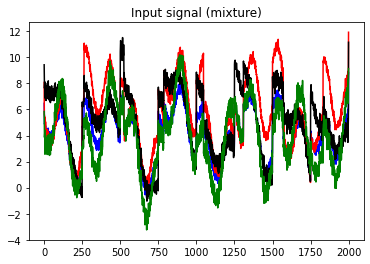

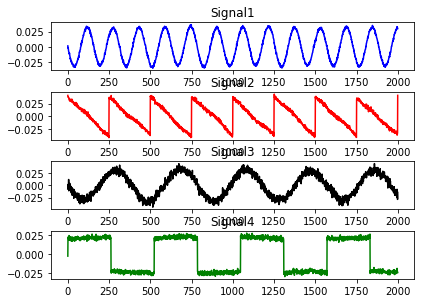

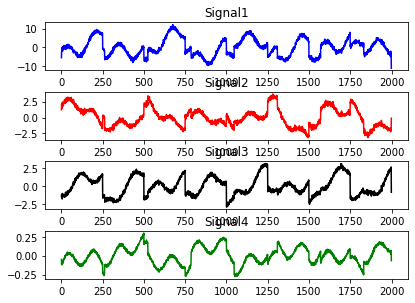

In [4]:
# 盲源分离：将不同的信号从混合体中分离出来的过程， ICA 独立成分分析算法
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA, FastICA

input_file = 'mixture_of_signals.txt'
X = np.loadtxt(input_file)

# ica
ica = FastICA(n_components=4)

# 基于 ICA 重构信号
signals_ica = ica.fit_transform(X)
# 提取混合矩阵
mixing_mat = ica.mixing_

# 与 PCA 基于正交成分重构信号 做对比
pca = PCA(n_components=4)
signals_pca = pca.fit_transform(X)

# plot
models = [X, signals_ica, signals_pca]
colors = ['blue', 'red', 'black', 'green']

plt.figure()
plt.title('Input signal (mixture)')
for i, (sig, color) in enumerate(zip(X.T, colors), 1):
    plt.plot(sig, color=color)

# 画出 ICA分离的信号
plt.figure()
plt.title('ICA separated signals')
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.94, top=0.94, wspace=0.25, hspace=0.45)
for i, (sig, color) in enumerate(zip(signals_ica.T, colors), 1):
    plt.subplot(4, 1, i)
    plt.title('Signal' + str(i))
    plt.plot(sig, color=color)

# 画出PCA分离的信号
plt.figure()
plt.title('PCA separated signals')
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.94, top=0.94, wspace=0.25, hspace=0.45)
for i, (sig, color) in enumerate(zip(signals_pca.T, colors), 1):
    plt.subplot(4, 1, i)
    plt.title('Signal' + str(i))
    plt.plot(sig, color=color)
    
plt.show()

In [5]:
# 局部二值模式直方图（Local Binary Patterns Histograms）创建人脸识别系统: 二值分类
import os
import cv2
import numpy as np
from sklearn import preprocessing

# 处理类标签编码
class LabelEncoder(object):
    
    # 标签str，训练使用int，要做一个映射
    def encode_labels(self, label_words):
        self.le = preprocessing.LabelEncoder()
        self.le.fit(label_words)
        
    # word -> num
    def word_to_num(self, label_word):
        return int(self.le.transform([label_word])[0])
    
    # num -> word
    def num_to_word(self, label_num):
        return self.le.inverse_transform(label_num)[0]
    
# extract images and labels
def get_images_and_labels(input_path):
    label_words = []
    
    # iter
    for root, dirs, files in os.walk(input_path):
        for filename in (x for x in files if x.endswith('.jpg')):
            filepath = os.path.join(root, filename)
            label_words.append(filepath.split('/')[-2])

    # initialize variables
    images = []
    le = LabelEncoder() 
    le.encode_labels(label_words)
    labels = []
    
    for root, dirs, files in os.walk(input_path):
        for filename in (x for x in files if x.endswith('.jpg')):
            filepath = os.path.join(root, filename)
            
            # 将当前图像读取为灰度格式
            image = cv2.imread(filepath, 0)
            
            # 提取标签
            name = filepath.split('/')[-2]
            
            # 人脸检测
            faces = faceCascade.detectMultiScale(image, 1.1, 2, minSize=(100,100))
            
            # Iterate through face rectangles: 提取ROI属性值
            for (x, y, w, h) in faces:
                images.append(image[y:y+h, x:x+w])
                labels.append(le.word_to_num(name))
    
    return images, labels, le

# main func
cascade_path = 'cascade_files/haarcascade_frontalface_alt.xml'
path_train = 'faces_dataset/train'
path_test = 'faces_dataset/test'

# 加载人脸级联文件
faceCascade = cv2.CascadeClassifier(cascade_path)
# 生成局部二值模式直方图 人脸识别器
recognizer = cv2.face.createLBPHFaceRecongnizer()

# extract images,labels,labelencodes from training datasets
images, labels, le = get_images_and_labels(path_train)
# fitting
print('\nTraining...')
recognizer.train(images, np.array(labels))

# perform testing
print("\nPerforming prediction on test images...")
stop_flag = False

for root, dirs, files in os.walk(path_test):
    for filename in (x for x in files if x.endswith('.jpg')):
        filepath = os.path.join(root, filename)
        
        predict_image = cv2.imread(filepath)
        faces = faceCascade.detectMultiScale(predict_image, 1.1, 2, minSize=(100,100))
        
        for (x, y, w, h) in faces:
            # predict the output
            predicted_index, conf = recognizer.predict(predict_image[y:y+h, x:x+w])
            
            # label -> words
            predicted_person = le.num_to_word(predicted_index)
            
            cv2.putText(predict_image, 'Prediction: ' + predicted_person, (10,60),
                       cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 6)
            cv2.imshow("Recognizing face", predict_image)
        c = cv2.waitKey(0)
        if c == 27:
            stop_flag = True
            break
    
    if stop_flag:
        break

AttributeError: module 'cv2' has no attribute 'face'